# Loan Default Prediction - Part 07 - Random Forest

This is an exploratory project for me to apply what I have learned in the Data Science and Machine Learning courses that I took this year. The data is from a Kaggle competition [Loan Default Prediction](https://www.kaggle.com/c/loan-default-prediction). 

This is Part 07 of the project: Random Forest.

In this part, I will use another decision-tree based model, Random Forest. I will first load the data. Models based on decision trees are usually less sensitive to the magnitude of data, so I will try both the original and the normalized data.

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import time
import project_utils as utils

In [2]:
# Load the training data (imputed but not normalized) from the CSV file

df, X, y = utils.load_csv('train_v2_preprocessed.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 1789 entries, f1_0 to loss
dtypes: float64(1789)
memory usage: 1.4 GB


In [3]:
# Separate training and validation sets

from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
X_train, y_train, X_valid, y_valid = utils.split_data(kf, X, y)

## Random Forest (Vanilla Version)

I will first try using all default setting and train a Random Forest model using the [sklearn.ensemble.RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) API.

Time elapsed (Training): 18.8420 s
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy (Training): 0.982199
ROCAUC Score (Training): 0.999669
PRAUC Score (Training): 0.746005
Accuracy (Validation): 0.909931
ROCAUC Score (Validation): 0.580758
PRAUC Score (Validation): 0.089851
Time elapsed (Evaluation): 2.3083 s


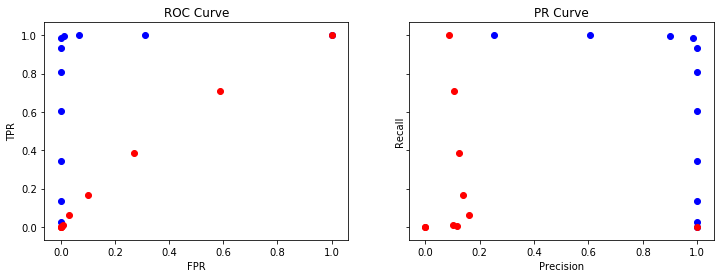

In [4]:
from sklearn import ensemble

clf = ensemble.RandomForestClassifier()
fit_time = utils.train_model(clf, X_train, y_train)
acc_score, rocauc_score, prauc_score, eval_time = utils.evaluate(clf, X_train, y_train, X_valid, y_valid)

I got very high scores (accuracy 0.98, ROCAUC almost 1.0, PRAUC 0.75) on the training set. Decision-tree-based models can perform very well on the training set because they can learn a rule for each training example they encounter. On the validation set, the scores are somewhat worse than the tuned Logistic Regression models I have trained in the previous parts. 

Now let's see how it does on the normalized data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 1789 entries, f3 to loss
dtypes: float64(1789)
memory usage: 1.4 GB
Time elapsed (Training): 19.1969 s
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy (Training): 0.982945
ROCAUC Score (Training): 0.999745
PRAUC Score (Training): 0.747309
Accuracy (Validation): 0.910216
ROCAUC Score (Validation): 0.575926
PRAUC Score (Validation): 0.071959
Time elapsed (Evaluation): 2.2713 s


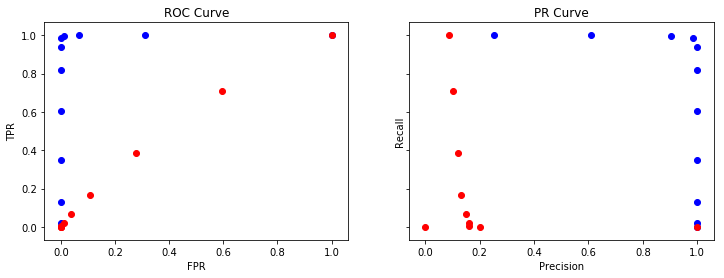

In [5]:
# Load the training data (imputed and normalized) from the CSV file
df, X, y = utils.load_csv('train_v2_preprocessed_normalized.csv')

# Separate training and validation sets
X_train, y_train, X_valid, y_valid = utils.split_data(kf, X, y)

# Train the model and evaluate
clf = ensemble.RandomForestClassifier()
fit_time = utils.train_model(clf, X_train, y_train)
acc_score, rocauc_score, prauc_score, eval_time = utils.evaluate(clf, X_train, y_train, X_valid, y_valid)

The scores on the training and the validation sets are almost the same as those from the original data. This illustrates that Random Forests' performance is the same for either normalized or unnormalized data.

I would also like to see whether specifying the class weights will help the model. After all, my data set has unbalanced classes.

Time elapsed (Training): 13.0768 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.981819
ROCAUC Score (Training): 0.999760
PRAUC Score (Training): 0.722756
Accuracy (Validation): 0.911164
ROCAUC Score (Validation): 0.574661
PRAUC Score (Validation): 0.028685
Time elapsed (Evaluation): 2.0853 s


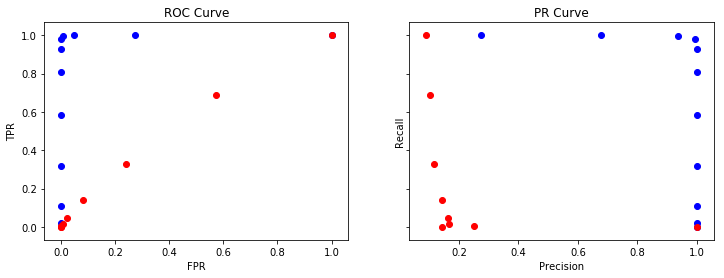

In [6]:
# Define weights for unbalanced classes

class_weight = {0: 1., 1: 10.}
clf = ensemble.RandomForestClassifier(class_weight=class_weight)
fit_time = utils.train_model(clf, X_train, y_train)
acc_score, rocauc_score, prauc_score, eval_time = utils.evaluate(clf, X_train, y_train, X_valid, y_valid)

Still not much difference, but ROCAUC improved from 0.58 to 0.60, and PRAUC improved from 0.03 to 0.08, so there is some improvement.

On the other hand, there is a significant discrepancy on the training and validation scores, which indicates overfitting. There are a few hyperparameters we can set for the Random Forest model in order to control how it grows and limit the extent of overfitting on the training data.

## Max Depth

Setting __max_depth__ allows us to control the depth of the trees in a Random Forest model. The trees stop growing after they reach the maximum depth.

In [7]:
ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

----- k = 1 -----
Time elapsed (Training): 1.2906 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=1, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.518335
ROCAUC Score (Training): 0.639450
PRAUC Score (Training): 0.161148
Accuracy (Validation): 0.520408
ROCAUC Score (Validation): 0.639827
PRAUC Score (Validation): 0.164358
Time elapsed (Evaluation): 1.1826 s


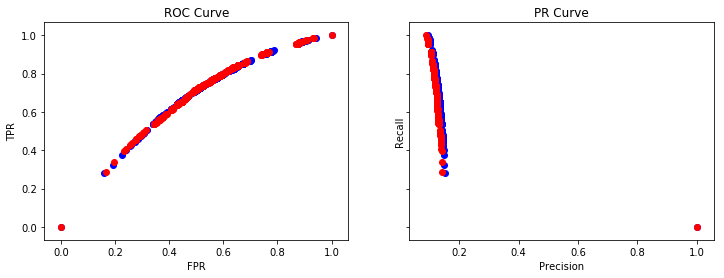

----- k = 2 -----
Time elapsed (Training): 1.9524 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=2, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.549291
ROCAUC Score (Training): 0.650118
PRAUC Score (Training): 0.070772
Accuracy (Validation): 0.547049
ROCAUC Score (Validation): 0.650104
PRAUC Score (Validation): 0.159873
Time elapsed (Evaluation): 1.2396 s


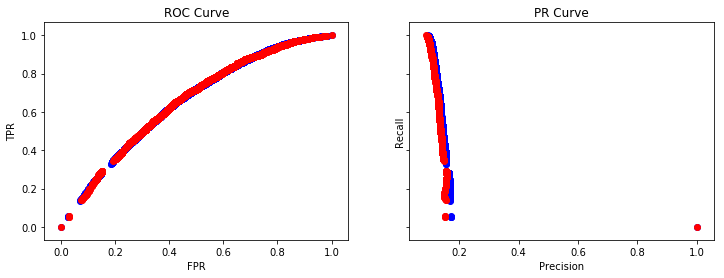

----- k = 3 -----
Time elapsed (Training): 2.5672 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.537120
ROCAUC Score (Training): 0.665354
PRAUC Score (Training): 0.109838
Accuracy (Validation): 0.542403
ROCAUC Score (Validation): 0.661115
PRAUC Score (Validation): 0.173139
Time elapsed (Evaluation): 1.3186 s


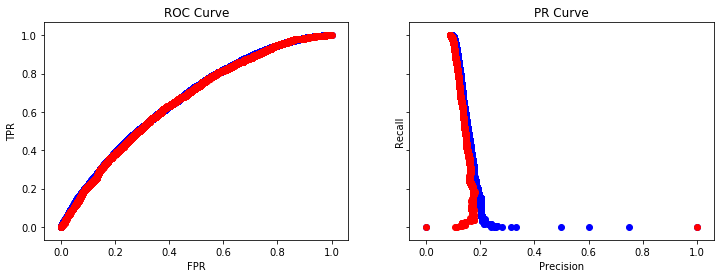

----- k = 4 -----
Time elapsed (Training): 3.2620 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.567590
ROCAUC Score (Training): 0.669379
PRAUC Score (Training): 0.064676
Accuracy (Validation): 0.575776
ROCAUC Score (Validation): 0.657981
PRAUC Score (Validation): 0.070909
Time elapsed (Evaluation): 1.4695 s


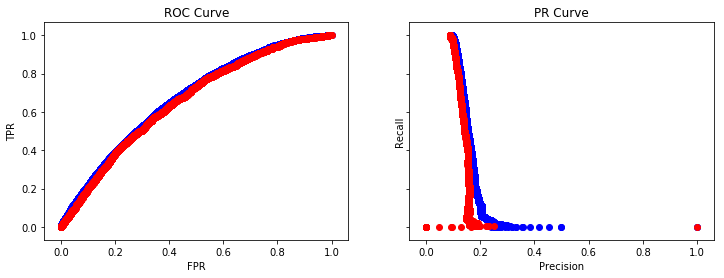

----- k = 5 -----
Time elapsed (Training): 4.4976 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.564639
ROCAUC Score (Training): 0.682745
PRAUC Score (Training): 0.122040
Accuracy (Validation): 0.567907
ROCAUC Score (Validation): 0.660786
PRAUC Score (Validation): 0.050647
Time elapsed (Evaluation): 1.5545 s


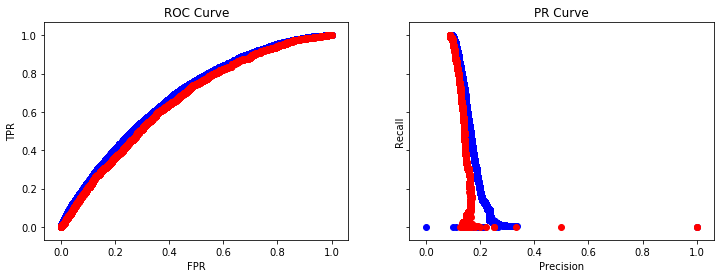

----- k = 6 -----
Time elapsed (Training): 5.9531 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=6, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.580627
ROCAUC Score (Training): 0.700396
PRAUC Score (Training): 0.087082
Accuracy (Validation): 0.584831
ROCAUC Score (Validation): 0.663436
PRAUC Score (Validation): 0.090148
Time elapsed (Evaluation): 1.8564 s


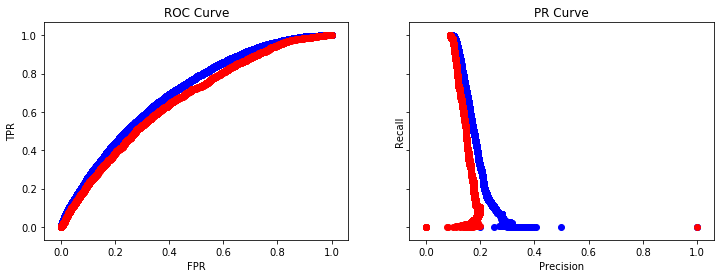

----- k = 7 -----
Time elapsed (Training): 6.3510 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=7, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.606511
ROCAUC Score (Training): 0.723637
PRAUC Score (Training): 0.155265
Accuracy (Validation): 0.599526
ROCAUC Score (Validation): 0.663421
PRAUC Score (Validation): 0.101101
Time elapsed (Evaluation): 2.3732 s


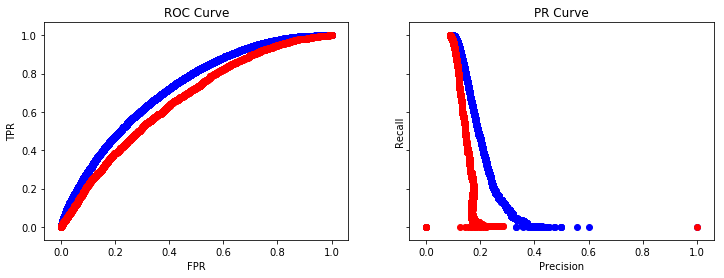

----- k = 8 -----
Time elapsed (Training): 7.7325 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=8, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.646475
ROCAUC Score (Training): 0.754688
PRAUC Score (Training): 0.134870
Accuracy (Validation): 0.624935
ROCAUC Score (Validation): 0.662735
PRAUC Score (Validation): 0.103421
Time elapsed (Evaluation): 2.0833 s


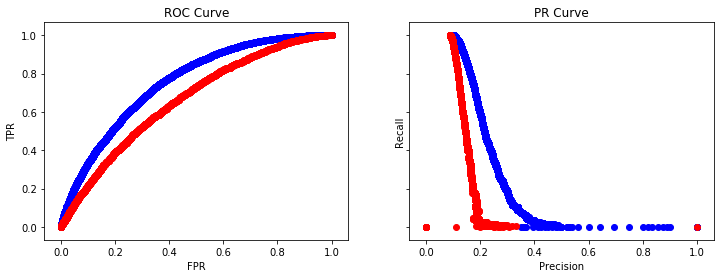

----- k = 9 -----
Time elapsed (Training): 8.2754 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=9, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.695530
ROCAUC Score (Training): 0.794871
PRAUC Score (Training): 0.185085
Accuracy (Validation): 0.660251
ROCAUC Score (Validation): 0.655146
PRAUC Score (Validation): 0.055210
Time elapsed (Evaluation): 2.5202 s


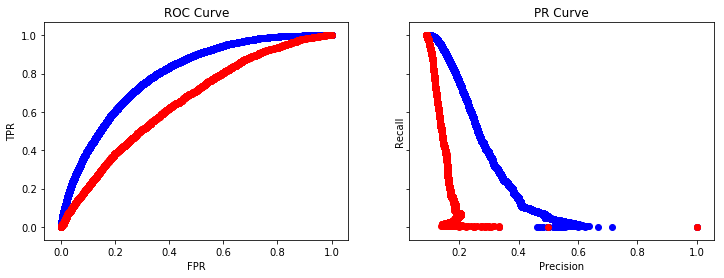

----- k = 10 -----
Time elapsed (Training): 8.0815 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.733538
ROCAUC Score (Training): 0.827615
PRAUC Score (Training): 0.240162
Accuracy (Validation): 0.690258
ROCAUC Score (Validation): 0.660497
PRAUC Score (Validation): 0.059946
Time elapsed (Evaluation): 1.7684 s


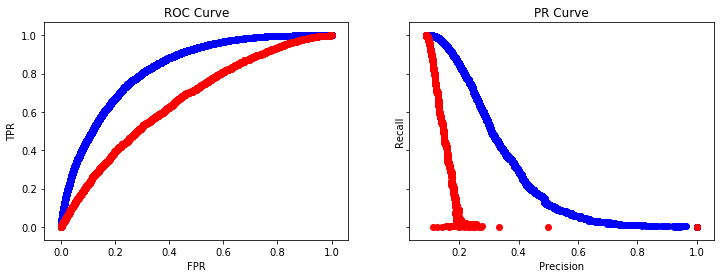

----- k = 11 -----
Time elapsed (Training): 8.3993 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=11, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.782462
ROCAUC Score (Training): 0.868689
PRAUC Score (Training): 0.308881
Accuracy (Validation): 0.724058
ROCAUC Score (Validation): 0.664706
PRAUC Score (Validation): 0.062219
Time elapsed (Evaluation): 1.8024 s


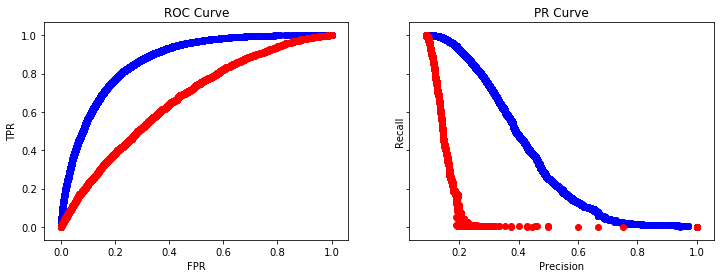

----- k = 12 -----
Time elapsed (Training): 8.9382 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.817247
ROCAUC Score (Training): 0.900002
PRAUC Score (Training): 0.382698
Accuracy (Validation): 0.748898
ROCAUC Score (Validation): 0.654172
PRAUC Score (Validation): 0.099048
Time elapsed (Evaluation): 2.0134 s


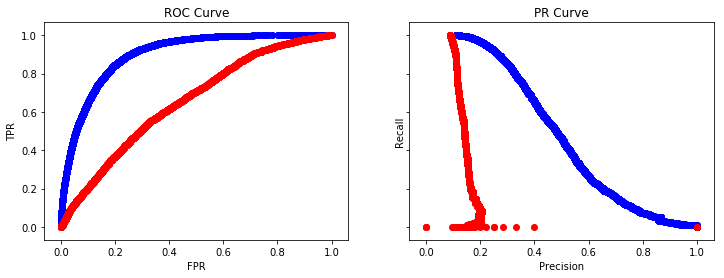

----- k = 13 -----
Time elapsed (Training): 9.6529 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=13, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.852494
ROCAUC Score (Training): 0.923802
PRAUC Score (Training): 0.451888
Accuracy (Validation): 0.777104
ROCAUC Score (Validation): 0.648711
PRAUC Score (Validation): 0.095743
Time elapsed (Evaluation): 1.9844 s


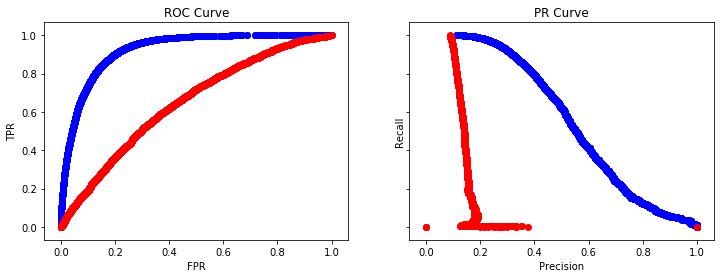

----- k = 14 -----
Time elapsed (Training): 10.1538 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=14, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.885501
ROCAUC Score (Training): 0.945782
PRAUC Score (Training): 0.542101
Accuracy (Validation): 0.800853
ROCAUC Score (Validation): 0.650934
PRAUC Score (Validation): 0.097125
Time elapsed (Evaluation): 1.9474 s


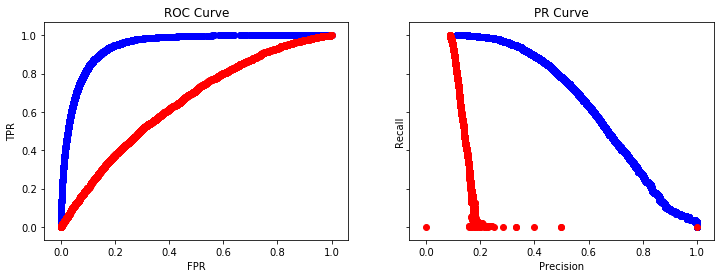

----- k = 15 -----
Time elapsed (Training): 10.1958 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.912724
ROCAUC Score (Training): 0.962678
PRAUC Score (Training): 0.612532
Accuracy (Validation): 0.818109
ROCAUC Score (Validation): 0.652727
PRAUC Score (Validation): 0.049915
Time elapsed (Evaluation): 2.0024 s


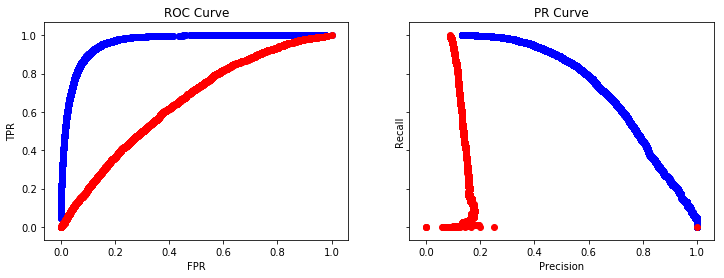

In [8]:
fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []; prauc_scores = []

for k in ks:
    print('----- k = %d -----' % k)
    clf = ensemble.RandomForestClassifier(class_weight=class_weight, max_depth=k)
    fit_time = utils.train_model(clf, X_train, y_train)
    acc_score, rocauc_score, prauc_score, eval_time = utils.evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score); prauc_scores.append(prauc_score)

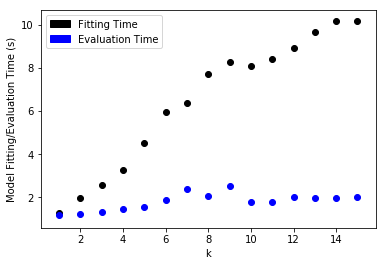

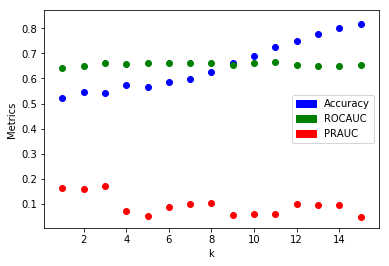

    0_k  1_Accuracy  2_ROCAUC   3_PRAUC  4_fit_time  5_eval_time
0     1    0.520408  0.639827  0.164358    1.290603     1.182609
1     2    0.547049  0.650104  0.159873    1.952393     1.239618
2     3    0.542403  0.661115  0.173139    2.567182     1.318581
3     4    0.575776  0.657981  0.070909    3.261960     1.469533
4     5    0.567907  0.660786  0.050647    4.497578     1.554493
5     6    0.584831  0.663436  0.090148    5.953117     1.856397
6     7    0.599526  0.663421  0.101101    6.350976     2.373242
7     8    0.624935  0.662735  0.103421    7.732537     2.083336
8     9    0.660251  0.655146  0.055210    8.275366     2.520200
9    10    0.690258  0.660497  0.059946    8.081458     1.768436
10   11    0.724058  0.664706  0.062219    8.399328     1.802423
11   12    0.748898  0.654172  0.099048    8.938152     2.013358
12   13    0.777104  0.648711  0.095743    9.652924     1.984370
13   14    0.800853  0.650934  0.097125   10.153782     1.947378
14   15    0.818109  0.65

In [9]:
utils.plot_metrics(ks, 'k', False, fit_times, eval_times, acc_scores, rocauc_scores, prauc_scores)

We can see that overfitting is more pronounced as the __max_depth__ goes up. The best ROCAUC occurs at __max_depth__=6, which is also where the curves of the training and the validation set start to split. Although the accuracy is highest at __max_depth__=15, as the classes are unbalanced, it doesn't necessarily mean a better model.

## Min Samples Split

Next, I will try __min_samples_split__, which is the minimum number of samples required to split an internal node.

In [10]:
ks = [2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

----- k = 2 -----
Time elapsed (Training): 15.1852 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.981523
ROCAUC Score (Training): 0.999830
PRAUC Score (Training): 0.724336
Accuracy (Validation): 0.911164
ROCAUC Score (Validation): 0.581892
PRAUC Score (Validation): 0.075220
Time elapsed (Evaluation): 2.4552 s


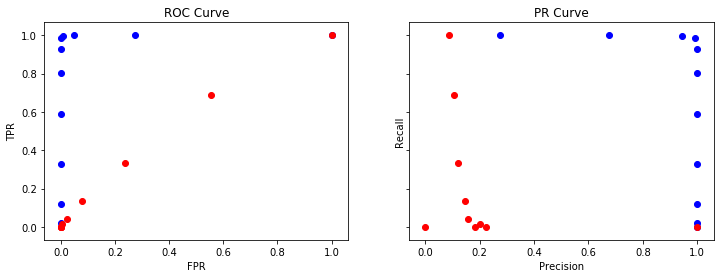

----- k = 5 -----
Time elapsed (Training): 14.8793 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.982661
ROCAUC Score (Training): 0.999779
PRAUC Score (Training): 0.399706
Accuracy (Validation): 0.910642
ROCAUC Score (Validation): 0.583794
PRAUC Score (Validation): 0.032014
Time elapsed (Evaluation): 1.9924 s


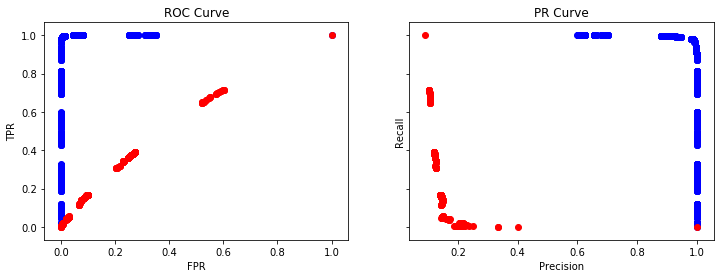

----- k = 10 -----
Time elapsed (Training): 12.4800 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.984534
ROCAUC Score (Training): 0.999428
PRAUC Score (Training): 0.752338
Accuracy (Validation): 0.909599
ROCAUC Score (Validation): 0.590662
PRAUC Score (Validation): 0.074894
Time elapsed (Evaluation): 1.9684 s


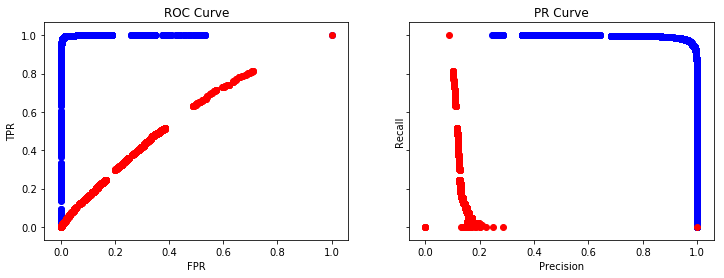

----- k = 20 -----
Time elapsed (Training): 12.2151 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.984332
ROCAUC Score (Training): 0.997907
PRAUC Score (Training): 0.747710
Accuracy (Validation): 0.903721
ROCAUC Score (Validation): 0.599983
PRAUC Score (Validation): 0.026927
Time elapsed (Evaluation): 2.0164 s


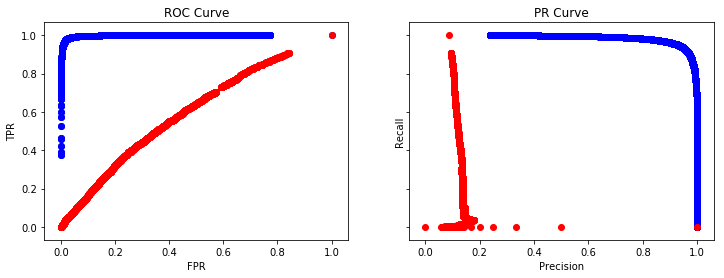

----- k = 50 -----
Time elapsed (Training): 11.6363 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.968451
ROCAUC Score (Training): 0.985904
PRAUC Score (Training): 0.753941
Accuracy (Validation): 0.880635
ROCAUC Score (Validation): 0.621444
PRAUC Score (Validation): 0.081342
Time elapsed (Evaluation): 2.1283 s


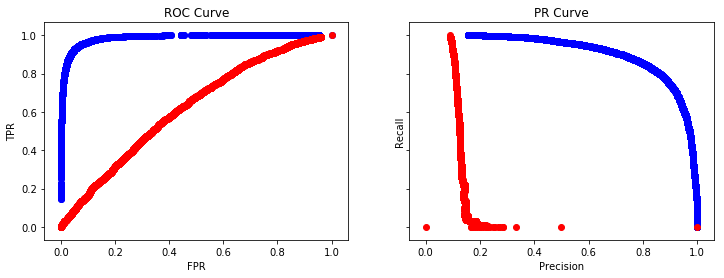

----- k = 100 -----
Time elapsed (Training): 10.8775 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.916398
ROCAUC Score (Training): 0.949123
PRAUC Score (Training): 0.612249
Accuracy (Validation): 0.833562
ROCAUC Score (Validation): 0.638015
PRAUC Score (Validation): 0.092749
Time elapsed (Evaluation): 2.0024 s


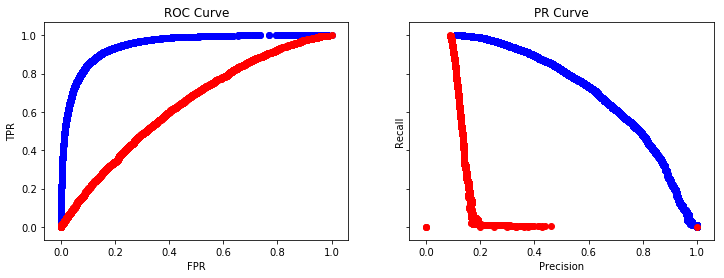

----- k = 200 -----
Time elapsed (Training): 10.2187 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.832713
ROCAUC Score (Training): 0.886124
PRAUC Score (Training): 0.392366
Accuracy (Validation): 0.773501
ROCAUC Score (Validation): 0.653849
PRAUC Score (Validation): 0.051896
Time elapsed (Evaluation): 3.1020 s


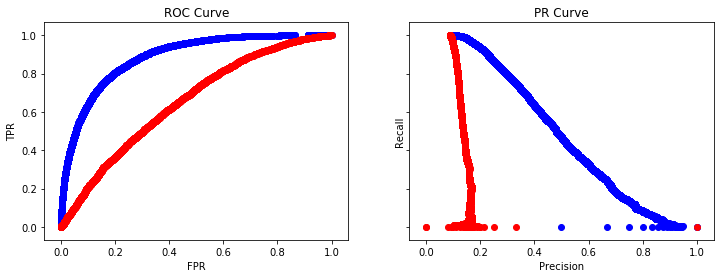

----- k = 500 -----
Time elapsed (Training): 8.3184 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=500, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.704406
ROCAUC Score (Training): 0.796113
PRAUC Score (Training): 0.202150
Accuracy (Validation): 0.673951
ROCAUC Score (Validation): 0.663266
PRAUC Score (Validation): 0.071405
Time elapsed (Evaluation): 1.7914 s


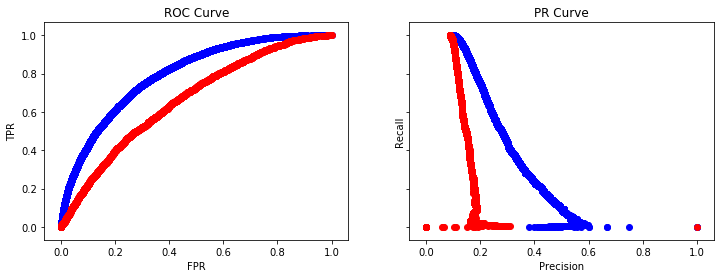

----- k = 1000 -----
Time elapsed (Training): 6.7828 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=1000, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.645409
ROCAUC Score (Training): 0.745277
PRAUC Score (Training): 0.132888
Accuracy (Validation): 0.632946
ROCAUC Score (Validation): 0.672045
PRAUC Score (Validation): 0.109079
Time elapsed (Evaluation): 1.6595 s


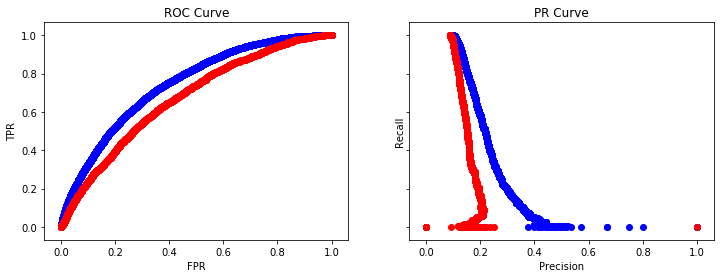

----- k = 2000 -----
Time elapsed (Training): 5.3993 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2000, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.599151
ROCAUC Score (Training): 0.710887
PRAUC Score (Training): 0.098999
Accuracy (Validation): 0.598056
ROCAUC Score (Validation): 0.669048
PRAUC Score (Validation): 0.068439
Time elapsed (Evaluation): 1.6105 s


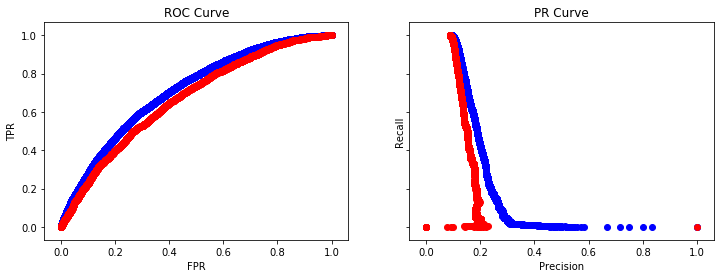

----- k = 5000 -----
Time elapsed (Training): 3.7968 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=5000, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.560242
ROCAUC Score (Training): 0.681733
PRAUC Score (Training): 0.076192
Accuracy (Validation): 0.565300
ROCAUC Score (Validation): 0.666641
PRAUC Score (Validation): 0.059250
Time elapsed (Evaluation): 1.4665 s


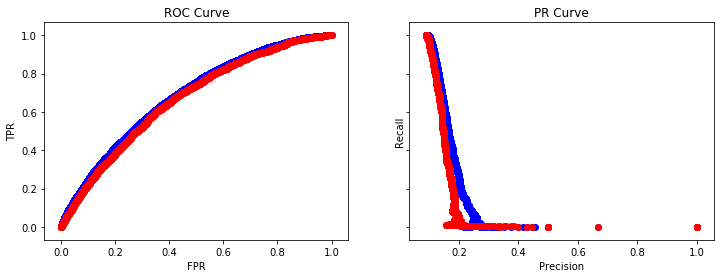

In [11]:
fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []; prauc_scores = []

for k in ks:
    print('----- k = %d -----' % k)
    clf = ensemble.RandomForestClassifier(class_weight=class_weight, min_samples_split=k)
    fit_time = utils.train_model(clf, X_train, y_train)
    acc_score, rocauc_score, prauc_score, eval_time = utils.evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score); prauc_scores.append(prauc_score)

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


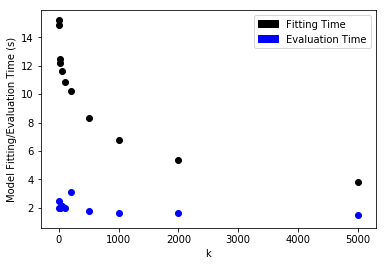

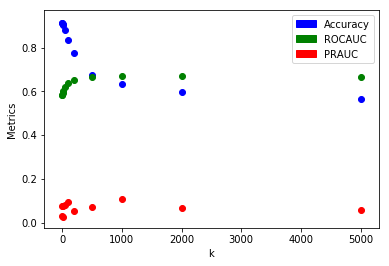

     0_k  1_Accuracy  2_ROCAUC   3_PRAUC  4_fit_time  5_eval_time
0      2    0.911164  0.581892  0.075220   15.185182     2.455220
1      5    0.910642  0.583794  0.032014   14.879260     1.992366
2     10    0.909599  0.590662  0.074894   12.480025     1.968374
3     20    0.903721  0.599983  0.026927   12.215109     2.016358
4     50    0.880635  0.621444  0.081342   11.636294     2.128321
5    100    0.833562  0.638015  0.092749   10.877535     2.002363
6    200    0.773501  0.653849  0.051896   10.218749     3.102012
7    500    0.673951  0.663266  0.071405    8.318350     1.791429
8   1000    0.632946  0.672045  0.109079    6.782826     1.659471
9   2000    0.598056  0.669048  0.068439    5.399279     1.610487
10  5000    0.565300  0.666641  0.059250    3.796791     1.466532


               0_k  1_Accuracy   2_ROCAUC    3_PRAUC  4_fit_time  5_eval_time
count    11.000000   11.000000  11.000000  11.000000   11.000000    11.000000
mean    807.909091    0.781189   0.630967   0.0675

In [12]:
utils.plot_metrics(ks, 'k', False, fit_times, eval_times, acc_scores, rocauc_scores, prauc_scores)

A larger __min_samples_split__ reduces the model complexity and overfitting. I got almost the same best ROCAUC at __min_samples_split__=1000 and 2000. The best value is likely to be somewhere around here.

## Min Samples Leaf

Next, I will try __min_samples_leaf__, which is the minimum number of samples required to be at a leaf node.

In [13]:
ks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

----- k = 1 -----
Time elapsed (Training): 12.6860 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.982803
ROCAUC Score (Training): 0.999824
PRAUC Score (Training): 0.727804
Accuracy (Validation): 0.911211
ROCAUC Score (Validation): 0.584882
PRAUC Score (Validation): 0.033344
Time elapsed (Evaluation): 1.9894 s


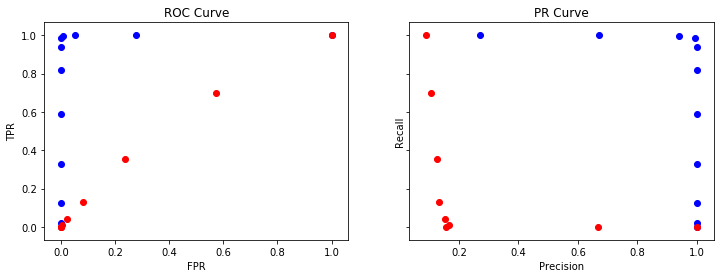

----- k = 2 -----
Time elapsed (Training): 12.6410 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.983716
ROCAUC Score (Training): 0.999537
PRAUC Score (Training): 0.775422
Accuracy (Validation): 0.910121
ROCAUC Score (Validation): 0.587799
PRAUC Score (Validation): 0.071869
Time elapsed (Evaluation): 1.9434 s


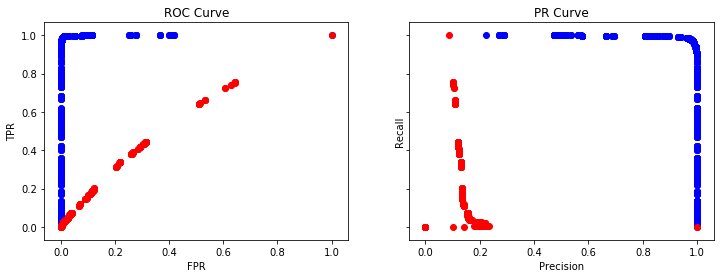

----- k = 5 -----
Time elapsed (Training): 11.8282 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.984498
ROCAUC Score (Training): 0.997496
PRAUC Score (Training): 0.846863
Accuracy (Validation): 0.901067
ROCAUC Score (Validation): 0.605398
PRAUC Score (Validation): 0.036049
Time elapsed (Evaluation): 1.9454 s


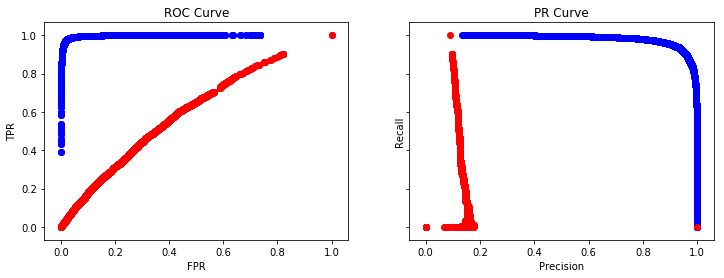

----- k = 10 -----
Time elapsed (Training): 11.5553 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.972871
ROCAUC Score (Training): 0.989453
PRAUC Score (Training): 0.734903
Accuracy (Validation): 0.885044
ROCAUC Score (Validation): 0.632469
PRAUC Score (Validation): 0.090923
Time elapsed (Evaluation): 2.0883 s


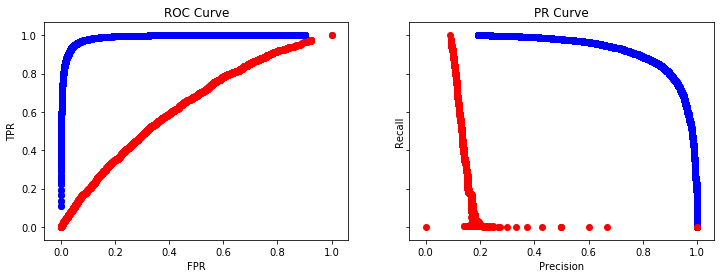

----- k = 20 -----
Time elapsed (Training): 10.0638 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.929968
ROCAUC Score (Training): 0.961943
PRAUC Score (Training): 0.651929
Accuracy (Validation): 0.846788
ROCAUC Score (Validation): 0.646527
PRAUC Score (Validation): 0.098194
Time elapsed (Evaluation): 1.9784 s


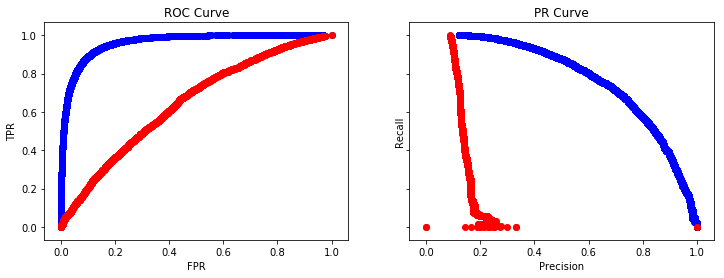

----- k = 50 -----
Time elapsed (Training): 8.7142 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.823599
ROCAUC Score (Training): 0.882031
PRAUC Score (Training): 0.368473
Accuracy (Validation): 0.767196
ROCAUC Score (Validation): 0.649701
PRAUC Score (Validation): 0.099650
Time elapsed (Evaluation): 1.8824 s


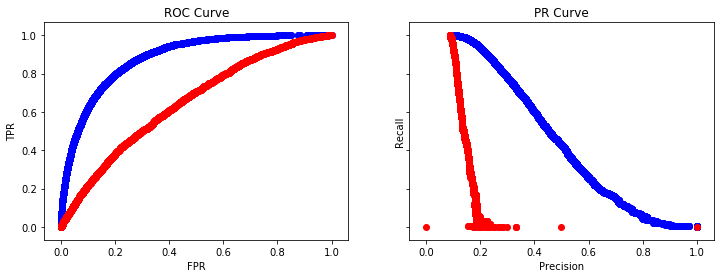

----- k = 100 -----
Time elapsed (Training): 7.7405 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=100,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.719932
ROCAUC Score (Training): 0.809653
PRAUC Score (Training): 0.223216
Accuracy (Validation): 0.689500
ROCAUC Score (Validation): 0.659195
PRAUC Score (Validation): 0.055232
Time elapsed (Evaluation): 1.7554 s


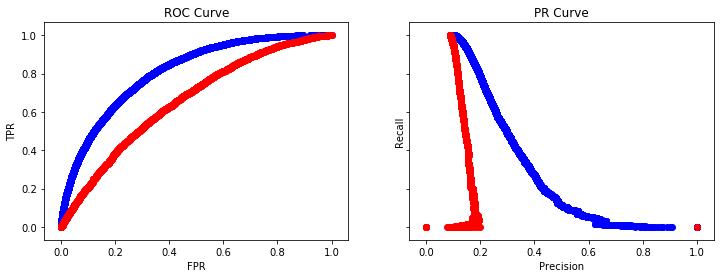

----- k = 200 -----
Time elapsed (Training): 6.5889 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.651465
ROCAUC Score (Training): 0.751442
PRAUC Score (Training): 0.190467
Accuracy (Validation): 0.639014
ROCAUC Score (Validation): 0.669720
PRAUC Score (Validation): 0.116109
Time elapsed (Evaluation): 1.7314 s


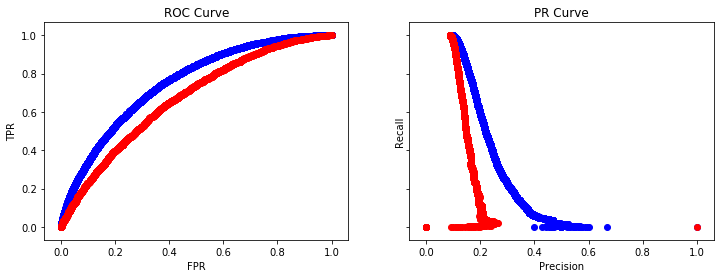

----- k = 500 -----
Time elapsed (Training): 5.3503 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=500,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.588639
ROCAUC Score (Training): 0.705865
PRAUC Score (Training): 0.144263
Accuracy (Validation): 0.589050
ROCAUC Score (Validation): 0.666179
PRAUC Score (Validation): 0.103024
Time elapsed (Evaluation): 1.5945 s


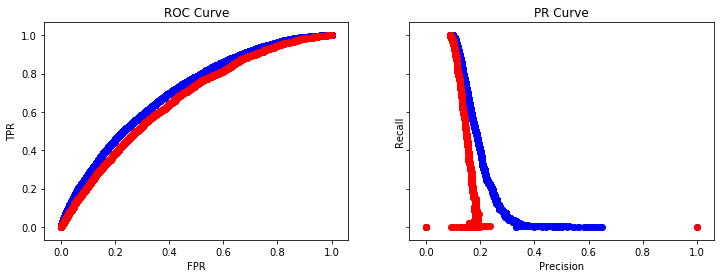

----- k = 1000 -----
Time elapsed (Training): 4.5795 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1000,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.571371
ROCAUC Score (Training): 0.689394
PRAUC Score (Training): 0.128394
Accuracy (Validation): 0.583266
ROCAUC Score (Validation): 0.668693
PRAUC Score (Validation): 0.115449
Time elapsed (Evaluation): 1.5055 s


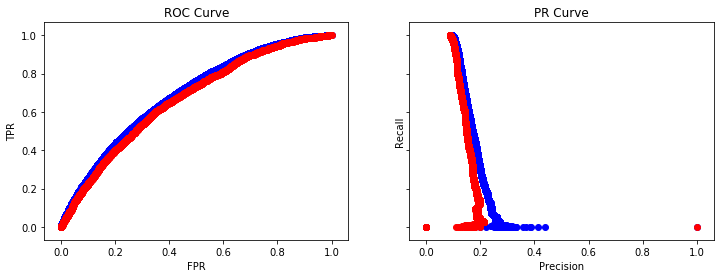

----- k = 2000 -----
Time elapsed (Training): 3.4719 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2000,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.554447
ROCAUC Score (Training): 0.674199
PRAUC Score (Training): 0.117496
Accuracy (Validation): 0.561839
ROCAUC Score (Validation): 0.662731
PRAUC Score (Validation): 0.101943
Time elapsed (Evaluation): 1.4375 s


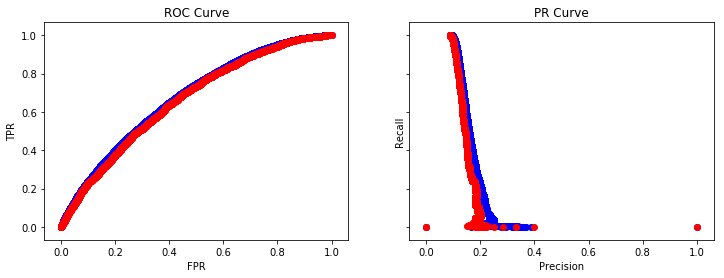

----- k = 5000 -----
Time elapsed (Training): 2.4972 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5000,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.536266
ROCAUC Score (Training): 0.661857
PRAUC Score (Training): 0.062934
Accuracy (Validation): 0.537379
ROCAUC Score (Validation): 0.659476
PRAUC Score (Validation): 0.083781
Time elapsed (Evaluation): 1.4755 s


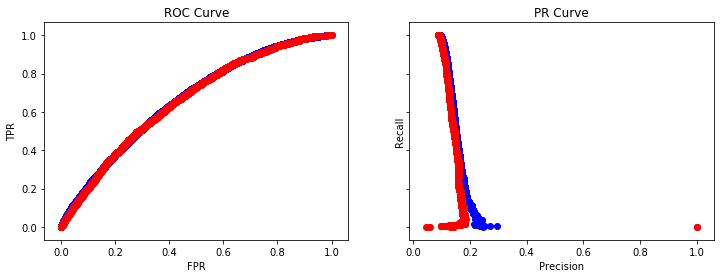

In [14]:
fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []; prauc_scores = []

for k in ks:
    print('----- k = %d -----' % k)
    clf = ensemble.RandomForestClassifier(class_weight=class_weight, min_samples_leaf=k)
    fit_time = utils.train_model(clf, X_train, y_train)
    acc_score, rocauc_score, prauc_score, eval_time = utils.evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score); prauc_scores.append(prauc_score)

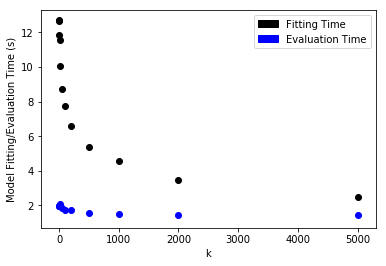

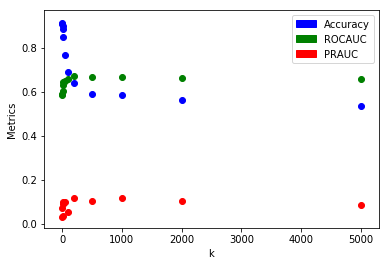

     0_k  1_Accuracy  2_ROCAUC   3_PRAUC  4_fit_time  5_eval_time
0      1    0.911211  0.584882  0.033344   12.685970     1.989380
1      2    0.910121  0.587799  0.071869   12.640960     1.943381
2      5    0.901067  0.605398  0.036049   11.828244     1.945367
3     10    0.885044  0.632469  0.090923   11.555305     2.088321
4     20    0.846788  0.646527  0.098194   10.063779     1.978370
5     50    0.767196  0.649701  0.099650    8.714222     1.882386
6    100    0.689500  0.659195  0.055232    7.740535     1.755440
7    200    0.639014  0.669720  0.116109    6.588886     1.731448
8    500    0.589050  0.666179  0.103024    5.350294     1.594479
9   1000    0.583266  0.668693  0.115449    4.579540     1.505520
10  2000    0.561839  0.662731  0.101943    3.471894     1.437543
11  5000    0.537379  0.659476  0.083781    2.497217     1.475517


               0_k  1_Accuracy   2_ROCAUC    3_PRAUC  4_fit_time  5_eval_time
count    12.000000   12.000000  12.000000  12.000000   12.0000

In [15]:
utils.plot_metrics(ks, 'k', False, fit_times, eval_times, acc_scores, rocauc_scores, prauc_scores)

Similar to __min_samples_split__, a larger __min_samples_leaf__ also reduces the model complexity and overfitting. I got the best ROCAUC at __min_samples_leaf__=500. This is somewhat consistent with the results from the __min_samples_split__ experiment. Assuming we have __min_samples_split__=1000 examples and splitting them evenly, we would get a leaf node with __min_samples_leaf__=500 examples.

## Max Leaf Nodes

The last hyperparameter I will try is __max_leaf_nodes__. The trees grow by adding the best leaf nodes until the number of leaf nodes reaches this number.

In [16]:
ks = [2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

----- k = 2 -----
Time elapsed (Training): 1.7145 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=2, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.514495
ROCAUC Score (Training): 0.639437
PRAUC Score (Training): 0.165672
Accuracy (Validation): 0.517800
ROCAUC Score (Validation): 0.642939
PRAUC Score (Validation): 0.164306
Time elapsed (Evaluation): 1.1756 s


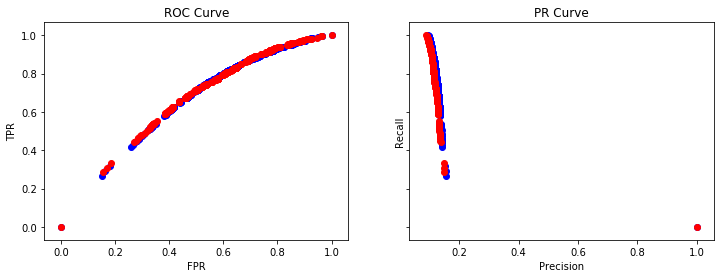

----- k = 5 -----
Time elapsed (Training): 2.7901 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=5, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.529191
ROCAUC Score (Training): 0.651949
PRAUC Score (Training): 0.104527
Accuracy (Validation): 0.536193
ROCAUC Score (Validation): 0.649866
PRAUC Score (Validation): 0.122637
Time elapsed (Evaluation): 1.2566 s


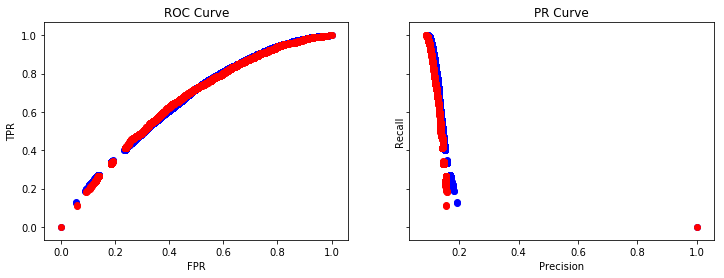

----- k = 10 -----
Time elapsed (Training): 3.4479 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=10, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.550192
ROCAUC Score (Training): 0.674898
PRAUC Score (Training): 0.077343
Accuracy (Validation): 0.553875
ROCAUC Score (Validation): 0.669469
PRAUC Score (Validation): 0.085033
Time elapsed (Evaluation): 1.3596 s


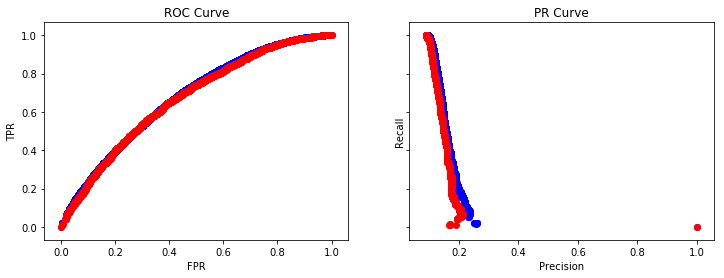

----- k = 20 -----
Time elapsed (Training): 4.1577 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=20, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.540912
ROCAUC Score (Training): 0.679102
PRAUC Score (Training): 0.095849
Accuracy (Validation): 0.542451
ROCAUC Score (Validation): 0.661661
PRAUC Score (Validation): 0.065123
Time elapsed (Evaluation): 1.4355 s


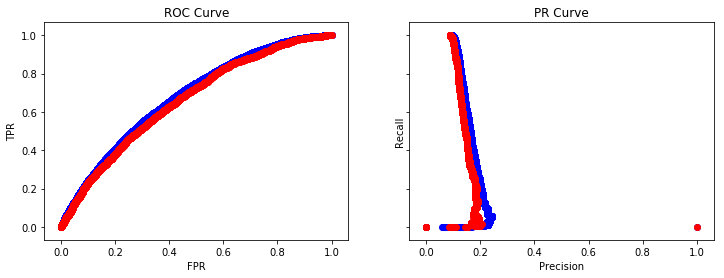

----- k = 50 -----
Time elapsed (Training): 5.2613 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=50, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.572236
ROCAUC Score (Training): 0.699052
PRAUC Score (Training): 0.128638
Accuracy (Validation): 0.577435
ROCAUC Score (Validation): 0.663125
PRAUC Score (Validation): 0.102833
Time elapsed (Evaluation): 1.5835 s


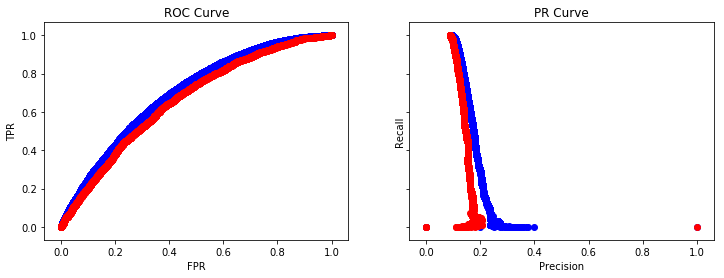

----- k = 100 -----
Time elapsed (Training): 5.9321 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=100, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.618517
ROCAUC Score (Training): 0.731066
PRAUC Score (Training): 0.102092
Accuracy (Validation): 0.606020
ROCAUC Score (Validation): 0.662256
PRAUC Score (Validation): 0.105011
Time elapsed (Evaluation): 1.5835 s


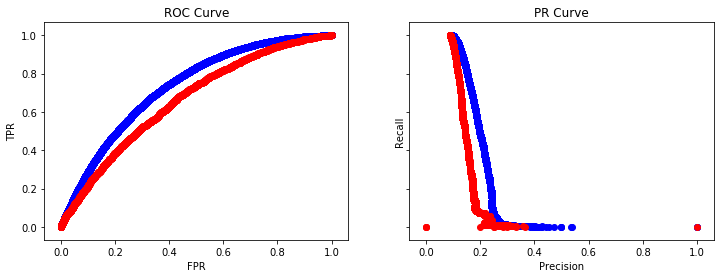

----- k = 200 -----
Time elapsed (Training): 7.2467 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=200, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.683547
ROCAUC Score (Training): 0.776931
PRAUC Score (Training): 0.142718
Accuracy (Validation): 0.654420
ROCAUC Score (Validation): 0.664230
PRAUC Score (Validation): 0.077094
Time elapsed (Evaluation): 1.6885 s


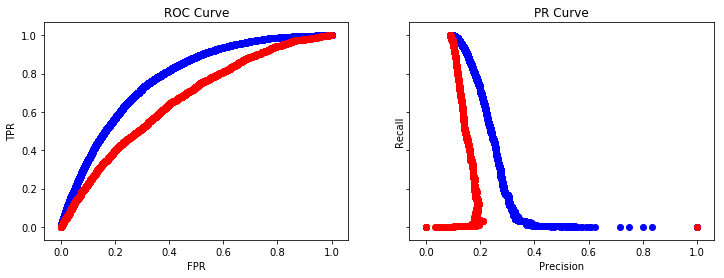

----- k = 500 -----
Time elapsed (Training): 8.6789 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=500, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.793211
ROCAUC Score (Training): 0.865038
PRAUC Score (Training): 0.298780
Accuracy (Validation): 0.739607
ROCAUC Score (Validation): 0.658799
PRAUC Score (Validation): 0.102409
Time elapsed (Evaluation): 1.7564 s


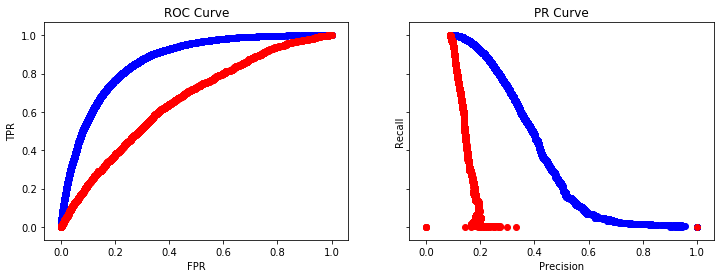

----- k = 1000 -----
Time elapsed (Training): 10.0928 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=1000, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.900481
ROCAUC Score (Training): 0.942519
PRAUC Score (Training): 0.564619
Accuracy (Validation): 0.819294
ROCAUC Score (Validation): 0.639003
PRAUC Score (Validation): 0.050445
Time elapsed (Evaluation): 1.8534 s


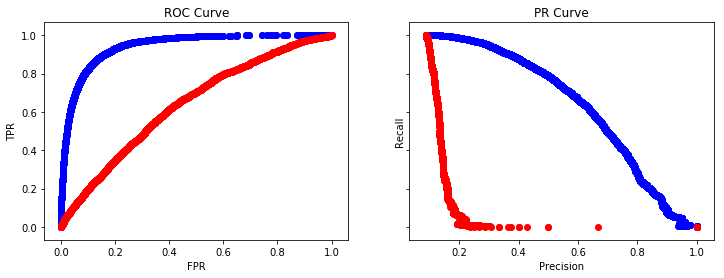

----- k = 2000 -----
Time elapsed (Training): 11.3834 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=2000, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.964184
ROCAUC Score (Training): 0.987990
PRAUC Score (Training): 0.780967
Accuracy (Validation): 0.877222
ROCAUC Score (Validation): 0.623119
PRAUC Score (Validation): 0.090632
Time elapsed (Evaluation): 2.0034 s


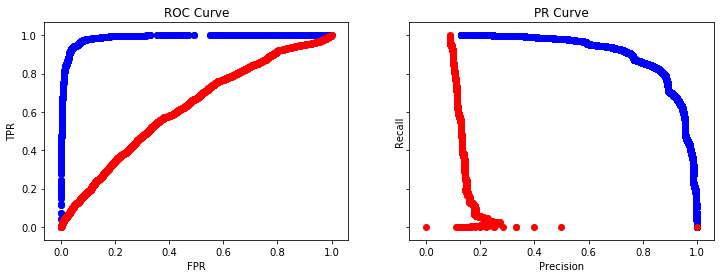

----- k = 5000 -----
Time elapsed (Training): 12.8529 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=5000, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.982092
ROCAUC Score (Training): 0.999668
PRAUC Score (Training): 0.694112
Accuracy (Validation): 0.910785
ROCAUC Score (Validation): 0.575405
PRAUC Score (Validation): 0.008652
Time elapsed (Evaluation): 1.9734 s


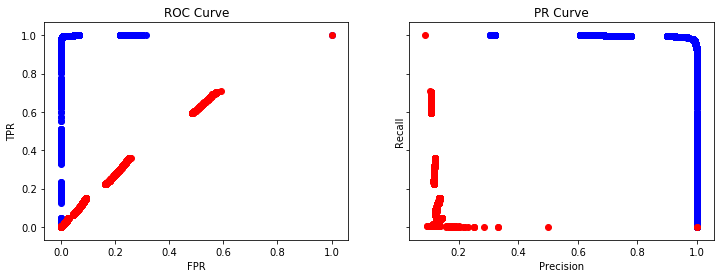

In [17]:
fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []; prauc_scores = []

for k in ks:
    print('----- k = %d -----' % k)
    clf = ensemble.RandomForestClassifier(class_weight=class_weight, max_leaf_nodes=k)
    fit_time = utils.train_model(clf, X_train, y_train)
    acc_score, rocauc_score, prauc_score, eval_time = utils.evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score); prauc_scores.append(prauc_score)

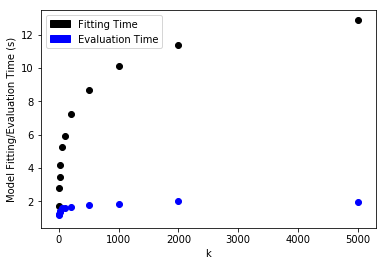

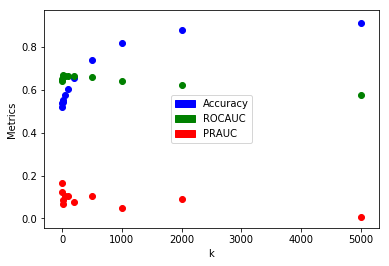

     0_k  1_Accuracy  2_ROCAUC   3_PRAUC  4_fit_time  5_eval_time
0      2    0.517800  0.642939  0.164306    1.714452     1.175626
1      5    0.536193  0.649866  0.122637    2.790112     1.256614
2     10    0.553875  0.669469  0.085033    3.447887     1.359580
3     20    0.542451  0.661661  0.065123    4.157687     1.435530
4     50    0.577435  0.663125  0.102833    5.261339     1.583495
5    100    0.606020  0.662256  0.105011    5.932097     1.583495
6    200    0.654420  0.664230  0.077094    7.246693     1.688462
7    500    0.739607  0.658799  0.102409    8.678903     1.756442
8   1000    0.819294  0.639003  0.050445   10.092783     1.853420
9   2000    0.877222  0.623119  0.090632   11.383360     2.003374
10  5000    0.910785  0.575405  0.008652   12.852904     1.973359


               0_k  1_Accuracy   2_ROCAUC    3_PRAUC  4_fit_time  5_eval_time
count    11.000000   11.000000  11.000000  11.000000   11.000000    11.000000
mean    807.909091    0.666828   0.646352   0.0885

In [18]:
utils.plot_metrics(ks, 'k', False, fit_times, eval_times, acc_scores, rocauc_scores, prauc_scores)

I am able to achieve ROCAUCs around 0.67 with all four methods.